In [1]:
#import conda
import shap
import numpy as np
import xgboost
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from interpret.glassbox import ExplainableBoostingClassifier
from interpret.privacy import DPExplainableBoostingClassifier, DPExplainableBoostingRegressor
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
from interpret.glassbox import ClassificationTree
from interpret import show
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

from interpret import show, set_visualize_provider
from interpret.provider import InlineProvider


In [2]:
def plot_confusion_matrix(cm, classes=[],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, figsize_val=6.5):

    fig=plt.figure(figsize=(figsize_val,figsize_val))
    plt.imshow(cm, interpolation='none', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,ha='right')
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [3]:
def generate_synthetic_dataset(num_samples, 
                               num_features, 
                               num_important_features, 
                               test_size=0.25, 
                               random_seed=None, 
                               noise=0.4):
    if random_seed is not None:
        np.random.seed(random_seed)

    # Generate random values for all features within a limited range
    dataset = np.random.uniform(0, 1, size=(num_samples, num_features))
    
    # Select important features
    important_features = np.random.choice(num_features, num_important_features, replace=False)
    
    # Assign random weights to the important features
    weights = np.random.uniform(0.5, 1.0, size=(num_samples,num_important_features))
    
    # **Apply weights to the important features in the dataset**
    dataset[:, important_features] = weights  # This scales the important features by their weights

    # Compute the y_linear combination of important features (now weights are already applied)
    y = dataset[:, important_features].sum(axis=1)
    
    # Add Gaussian noise to simulate real-world imperfections
    y += np.random.normal(0, noise, size=num_samples)
    
    # Normalize y to the range [0, 1]
    y_min, y_max = y.min(), y.max()
    y = (y - y_min) / (y_max - y_min)
    
    
    # Split dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        dataset, y, test_size=test_size, random_state=random_seed
    )

    # Create binary target variables based on a threshold of 0.5
    y_train_d = (y_train >= 0.5).astype(int)
    y_test_d = (y_test >= 0.5).astype(int)
    
    return X_train, X_test, y_train, y_test, important_features, y_train_d, y_test_d


In [13]:
set_visualize_provider(InlineProvider())
X_train, X_test, y_train, y_test, important_features, y_train_d, y_test_d  = generate_synthetic_dataset(num_samples=10000, 
                                                                                                        num_features=8, 
                                                                                                        num_important_features=1, 
                                                                                                        random_seed=42)
print(important_features)

dt = ClassificationTree(random_state=1)
dt.fit(X_train, y_train_d)
score = dt.score(X_test, y_test_d)

# make a prediction
print(score)
predictions = dt.predict(X_test)


[0]
0.6084


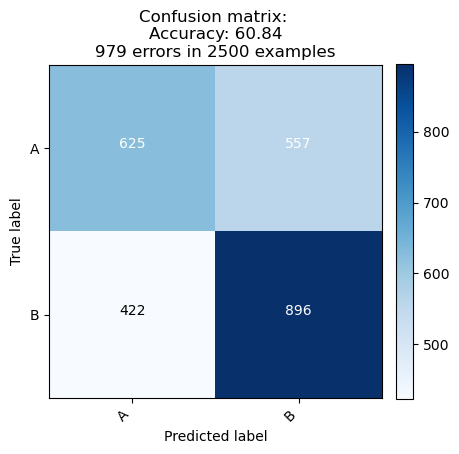

In [14]:
M = confusion_matrix(y_test_d, predictions)
    
# Calculate number of errors and create the description strings
a = "%d errors in %d examples" % (np.sum(y_test_d != predictions), y_test_d.shape[0])
b = "Accuracy: " + str(round(100 - np.sum(y_test_d != predictions) * 100 / y_test_d.shape[0], 2))

figsize_val = 4.5  # Customize the size if needed
classes_in = ['A', 'B']  # Adjust the class names if necessary
plot_confusion_matrix(M, classes=classes_in, figsize_val=figsize_val, title='Confusion matrix: ' + '\n' + str(b) + '\n' + str(a))

In [15]:
dt_global = dt.explain_global()
show(dt_global)
dt_local = dt.explain_local(X_test[:50], y_test_d[:50])
show(dt_local)

In [7]:
set_visualize_provider(InlineProvider())
X_train, X_test, y_train, y_test, important_features, y_train_d, y_test_d  = generate_synthetic_dataset(num_samples=10000, 
                                                                                                        num_features=8, 
                                                                                                        num_important_features=2, 
                                                                                                        random_seed=42)
print(important_features)

dt = ClassificationTree(random_state=1)
dt.fit(X_train, y_train_d)
score = dt.score(X_test, y_test_d)

# make a prediction
print(score)
predictions = dt.predict(X_test)
dt_global = dt.explain_global()

[0 6]
0.6416


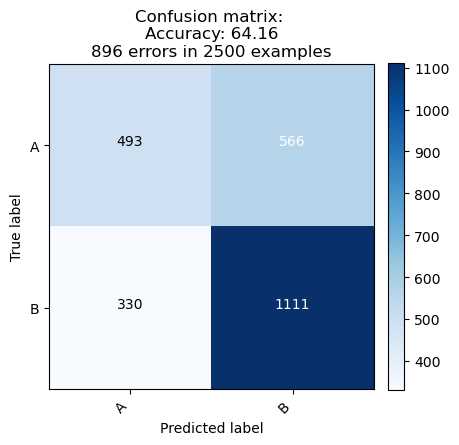

In [8]:
M = confusion_matrix(y_test_d, predictions)
    
# Calculate number of errors and create the description strings
a = "%d errors in %d examples" % (np.sum(y_test_d != predictions), y_test_d.shape[0])
b = "Accuracy: " + str(round(100 - np.sum(y_test_d != predictions) * 100 / y_test_d.shape[0], 2))

figsize_val = 4.5  # Customize the size if needed
classes_in = ['A', 'B']  # Adjust the class names if necessary
plot_confusion_matrix(M, classes=classes_in, figsize_val=figsize_val, title='Confusion matrix: ' + '\n' + str(b) + '\n' + str(a))

In [9]:
show(dt_global)

dt_local = dt.explain_local(X_test[:50], y_test_d[:50])
show(dt_local)

In [10]:
set_visualize_provider(InlineProvider())
X_train, X_test, y_train, y_test, important_features, y_train_d, y_test_d  = generate_synthetic_dataset(num_samples=10000, 
                                                                                                        num_features=8, 
                                                                                                        num_important_features=3, 
                                                                                                        random_seed=42)
print(important_features)

dt = ClassificationTree(random_state=1)
dt.fit(X_train, y_train_d)
score = dt.score(X_test, y_test_d)

# make a prediction
print(score)
predictions = dt.predict(X_test)
dt_global = dt.explain_global()

[0 6 7]
0.6628


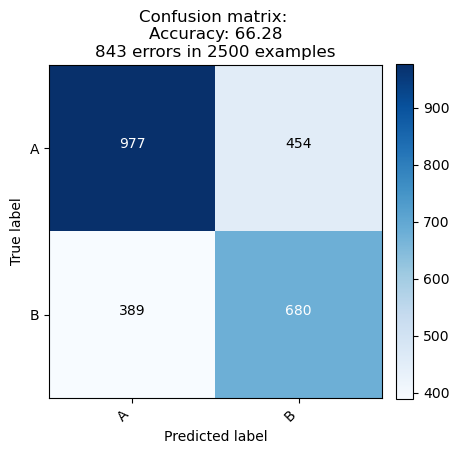

In [11]:
M = confusion_matrix(y_test_d, predictions)
    
# Calculate number of errors and create the description strings
a = "%d errors in %d examples" % (np.sum(y_test_d != predictions), y_test_d.shape[0])
b = "Accuracy: " + str(round(100 - np.sum(y_test_d != predictions) * 100 / y_test_d.shape[0], 2))

figsize_val = 4.5  # Customize the size if needed
classes_in = ['A', 'B']  # Adjust the class names if necessary
plot_confusion_matrix(M, classes=classes_in, figsize_val=figsize_val, title='Confusion matrix: ' + '\n' + str(b) + '\n' + str(a))

In [12]:
show(dt_global)

dt_local = dt.explain_local(X_test[:50], y_test_d[:50])
show(dt_local)